## Background:

We are a portfolio investment company and we make investments in the emerging markets around the world. Our company profits by investing in profitable companies, buying, holding and selling company stocks based on value investing principles.

Our goal is to establish a robust intelligent system to aid our value investing efforts using stock market data. We make investment decisions and based on intrinsic value of companies and do not trade on the basis of daily market volatility. Our profit realization strategy typically involves weekly, monthly and quarterly performance of stocks we buy or hold.


### Data Description:

You are given a set of portfolio companies trading data from emerging markets including 2020 Q1-Q2-Q3-Q4 2021 Q1 stock prices. Each company stock is provided in different sheets. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. Use only 2020 data and predict with 2021 Q1 data.

### Goal(s):

Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.

### Success Metrics:

Evaluate on the basis of capital returns. Use Bollinger Bands to measure your systems effectiveness.

In [1]:
#Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from datetime import datetime
import os


### Data Exploration

In [2]:
# Load the Dataset

Data = pd.read_csv('C:\\Users\\Public\\Sberbank.csv')
Dataset = Data.copy()

In [3]:
Dataset.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,31-Mar-21,291.02,294.00,294.42,290.26,"47,000,000.00",-0.76%
1,30-Mar-21,293.25,294.86,295.72,291.50,"38,810,000.00",-0.02%
2,29-Mar-21,293.30,289.72,294.09,289.26,"43,680,000.00",0.71%
3,26-Mar-21,291.22,288.63,292.75,288.32,"56,070,000.00",1.59%
4,25-Mar-21,286.66,286.50,287.03,283.85,"35,220,000.00",0.30%


In [4]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1065 non-null   object 
 1    Price    1065 non-null   float64
 2    Open     1065 non-null   float64
 3    High     1065 non-null   float64
 4    Low      1065 non-null   float64
 5     Vol.    1065 non-null   object 
 6   Change %  1065 non-null   object 
dtypes: float64(4), object(3)
memory usage: 58.4+ KB


In [5]:
Dataset.describe()

,Price,Open,High,Low
count,1065.000000,1065.000000,1065.000000,1065.000000
mean,215.096225,215.062911,217.526948,212.484338
std,33.843514,33.799929,34.082267,33.513738
min,139.000000,139.650000,142.210000,136.200000
25%,191.000000,191.160000,193.270000,188.200000
50%,216.710000,216.900000,219.180000,214.610000
75%,237.500000,237.500000,239.770000,235.000000
max,293.300000,294.860000,296.070000,291.500000


In [6]:
Dataset.corr()

C:\Users\Dorcas Taiwo\AppData\Local\Temp\ipykernel_20376\497014891.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Dataset.corr()


,Price,Open,High,Low
Price,1.000000,0.994382,0.997103,0.997383
Open,0.994382,1.000000,0.997728,0.996862
High,0.997103,0.997728,1.000000,0.995828
Low,0.997383,0.996862,0.995828,1.000000


In [7]:
Dataset['Date'] = pd.to_datetime(Dataset["Date"])
Dataset['Change %'] = Dataset['Change %'].str.rstrip("%").astype(float)

In [8]:
Dataset['Month'] = Dataset["Date"].dt.month
Dataset['WeekNum'] = Dataset["Date"].dt.week
Dataset['Quarter'] = Dataset["Date"].dt.quarter
Dataset['Year'] = Dataset["Date"].dt.year

C:\Users\Dorcas Taiwo\AppData\Local\Temp\ipykernel_20376\1628503213.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  Dataset['WeekNum'] = Dataset["Date"].dt.week


In [ ]:
#Dataset['Vol.'] = Dataset['Vol.'].astype(float)

In [9]:
Dataset.head()

,Date,Price,Open,High,Low,Vol.,Change %,Month,WeekNum,Quarter,Year
0,2021-03-31,291.02,294.00,294.42,290.26,"47,000,000.00",-0.76,3,13,1,2021
1,2021-03-30,293.25,294.86,295.72,291.50,"38,810,000.00",-0.02,3,13,1,2021
2,2021-03-29,293.30,289.72,294.09,289.26,"43,680,000.00",0.71,3,13,1,2021
3,2021-03-26,291.22,288.63,292.75,288.32,"56,070,000.00",1.59,3,12,1,2021
4,2021-03-25,286.66,286.50,287.03,283.85,"35,220,000.00",0.30,3,12,1,2021


In [10]:
month_dict = {1:'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 
              11: 'Nov', 12: 'Dec'}
Quarter_dict = {1:"Q1", 2:'Q2', 3:'Q3', 4:'Q4'}

In [11]:
Dataset['Month'] = Dataset.Month.map(month_dict)
Dataset['Quarter'] = Dataset.Quarter.map(Quarter_dict)

In [12]:
# Using + operator to combine two columns
# Example df["Period"] = df['Courses'].astype(str) +"-"+ df["Duration"]
# Example df['var3'] = df[['var1', 'var2']].astype(str).apply(lambda x: ''.join(x), axis=1)

Dataset["Quarter/Year"] = Dataset[['Quarter', 'Year']].astype(str).apply(lambda x: ''.join(x), axis=1)

In [13]:
Dataset.head()

,Date,Price,Open,High,Low,Vol.,Change %,Month,WeekNum,Quarter,Year,Quarter/Year
0,2021-03-31,291.02,294.00,294.42,290.26,"47,000,000.00",-0.76,Mar,13,Q1,2021,Q12021
1,2021-03-30,293.25,294.86,295.72,291.50,"38,810,000.00",-0.02,Mar,13,Q1,2021,Q12021
2,2021-03-29,293.30,289.72,294.09,289.26,"43,680,000.00",0.71,Mar,13,Q1,2021,Q12021
3,2021-03-26,291.22,288.63,292.75,288.32,"56,070,000.00",1.59,Mar,12,Q1,2021,Q12021
4,2021-03-25,286.66,286.50,287.03,283.85,"35,220,000.00",0.30,Mar,12,Q1,2021,Q12021


### Data Preprocessing

In [14]:
train = Dataset.loc[Dataset['Year'] < 2021]
test = Dataset.loc[Dataset['Year'] >= 2021]

In [82]:
print(train.count())
print(test.count())

Date            1004
 Price          1004
 Open           1004
 High           1004
 Low            1004
  Vol.          1004
Change %        1004
Month           1004
WeekNum         1004
Quarter         1004
Year            1004
Quarter/Year    1004
dtype: int64 Date            61
 Price          61
 Open           61
 High           61
 Low            61
  Vol.          61
Change %        61
Month           61
WeekNum         61
Quarter         61
Year            61
Quarter/Year    61
dtype: int64


In [16]:
train_dates = train['Date']
train_dates 

61     2020-12-30
62     2020-12-29
63     2020-12-28
64     2020-12-25
65     2020-12-24
          ...    
1060   2017-01-09
1061   2017-01-06
1062   2017-01-05
1063   2017-01-04
1064   2017-01-03
Name: Date, Length: 1004, dtype: datetime64[ns]

In [17]:
test_dates = test['Date']
test_dates 

0    2021-03-31
1    2021-03-30
2    2021-03-29
3    2021-03-26
4    2021-03-25
        ...    
56   2021-01-11
57   2021-01-08
58   2021-01-06
59   2021-01-05
60   2021-01-04
Name: Date, Length: 61, dtype: datetime64[ns]

In [18]:
cols = list(train)[1:5]
train_col = train[cols].astype(float)
train_col

,Price,Open,High,Low
61,271.65,272.49,274.24,270.12
62,272.00,275.91,276.43,271.26
63,274.70,270.90,275.19,269.73
64,270.64,269.97,271.00,268.28
65,269.32,271.98,272.82,267.13
...,...,...,...,...
1060,168.35,171.37,172.39,168.05
1061,170.69,172.40,173.75,169.50
1062,171.90,176.31,177.28,171.54
1063,175.95,178.90,179.41,174.23


In [19]:
test_col = test[cols].astype(float)
test_col

,Price,Open,High,Low
0,291.02,294.00,294.42,290.26
1,293.25,294.86,295.72,291.50
2,293.30,289.72,294.09,289.26
3,291.22,288.63,292.75,288.32
4,286.66,286.50,287.03,283.85
...,...,...,...,...
56,289.49,282.86,292.95,279.48
57,283.64,275.11,283.99,275.11
58,272.93,275.94,275.94,271.62
59,275.20,272.69,275.70,270.28


In [21]:
#test_array = (test_col.values.to_numpy())
test_array = test_col.values
test_array.shape

(61, 4)

<Axes: >

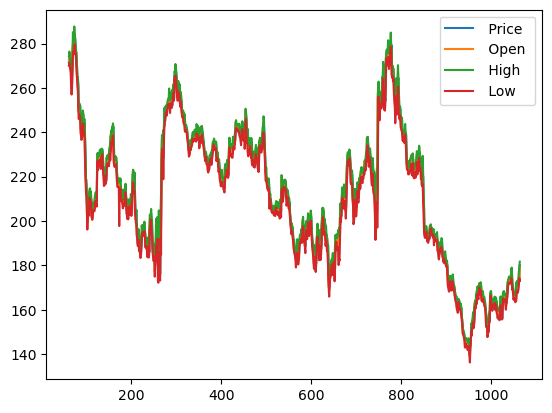

In [22]:
#plotting 2017 - 2020 data 

dt_plot = train_col
dt_plot.plot.line()

In [23]:
# Normalizing the Dataset

scalar = StandardScaler()
scalar = scalar.fit(train_col)
train_col_scaled = scalar.transform(train_col)

In [24]:
train_col_scaled.shape

(1004, 4)

In [25]:
# Preparing and Reshaping the input into n_samples by timesteps

train_X = []
train_Y =[]

In [26]:
#Defining number of days we want to predict into the future and number of days used to predict the future.

n_future = 1
n_past = 7

In [27]:
for i in range(n_past, len(train_col_scaled) -  n_future+1):
    train_X.append(train_col_scaled[i - n_past:i, 0:train_col.shape[1]])
    train_Y.append(train_col_scaled[i + n_future-1:i + n_future, 0])

In [28]:
train_X, train_Y = np.array(train_X), np.array(train_Y)

In [29]:
print(train_X.shape)
print(train_Y.shape)

(997, 7, 4)
(997, 1)


### Training LSTM network

In [30]:
model = Sequential()

In [31]:
model.add(LSTM(64, activation= "relu", input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences= True))
model.add(LSTM(32, activation= "relu", return_sequences= False))
model.add(Dropout(0.2))
model.add(Dense(train_Y.shape[1]))

In [32]:
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 64)             17664     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


In [33]:
#fit model

History = model.fit(train_X, train_Y, epochs=15, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/15
50/50 [==============================] - 3s 11ms/step - loss: 0.2944 - val_loss: 0.2982
Epoch 2/15
50/50 [==============================] - 0s 6ms/step - loss: 0.0744 - val_loss: 0.1582
Epoch 3/15
50/50 [==============================] - 0s 6ms/step - loss: 0.0564 - val_loss: 0.1491
Epoch 4/15
50/50 [==============================] - 0s 6ms/step - loss: 0.0440 - val_loss: 0.0948
Epoch 5/15
50/50 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.0514
Epoch 6/15
50/50 [==============================] - 0s 6ms/step - loss: 0.0466 - val_loss: 0.0101
Epoch 7/15
50/50 [==============================] - 0s 6ms/step - loss: 0.0389 - val_loss: 0.2289
Epoch 8/15
50/50 [==============================] - 0s 6ms/step - loss: 0.0378 - val_loss: 0.1571
Epoch 9/15
50/50 [==============================] - 0s 6ms/step - loss: 0.0332 - val_loss: 0.0346
Epoch 10/15
50/50 [==============================] - 0s 6ms/step - loss: 0.0312 - val_loss: 0.0292
Epoch 11/15
50/50 

In [84]:
# Calling `save('my_model.keras')` creates a zip archive `my_model.keras`.
#model.save("valueinvestor1")

# It can be used to reconstruct the model identically.
#reconstructed_model = keras.models.load_model("my_model.keras")


INFO:tensorflow:Assets written to: valueinvestor1\assets


INFO:tensorflow:Assets written to: valueinvestor1\assets


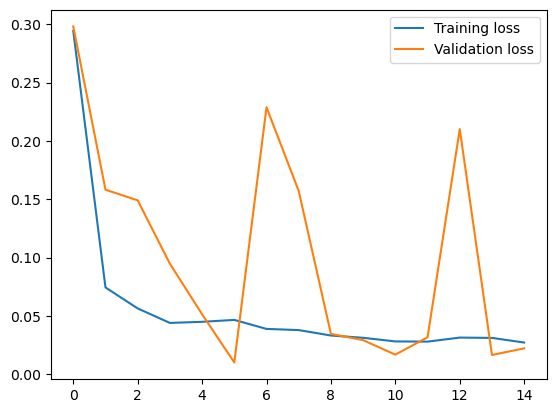

In [34]:
plt.plot(History.history['loss'], label='Training loss')
plt.plot(History.history['val_loss'], label = 'Validation loss')
plt.legend()

### Predicting on Test Dataset

In [35]:
#test_array = (test_col.values.to_numpy())
test_dates_array = test_dates.values
test_dates_array = np.reshape(test_dates_array, (-1,1))
test_dates_array.shape

(61, 1)

In [36]:
# Preparing test data for prediction

test_X = []
test_Y =[]

In [37]:
for i in range(n_past, len(test_col) -  n_future+1):
    test_X.append(test_array[i - n_past:i, 0:test_col.shape[1]])
    test_Y.append(test_array[i + n_future-1:i + n_future, 0])

In [38]:
test_X, test_Y = np.array(test_X), np.array(test_Y)

In [39]:
test_X.shape

(54, 7, 4)

In [40]:
test_Y.shape

(54, 1)

In [41]:
# for daily prediction

forecast =  model.predict(test_X)

2/2 [==============================] - 0s 13ms/step


In [42]:
forecast.shape

(54, 1)

In [44]:
forecast_dates=[]
for i in range(n_past, len(test_dates_array) -  n_future+1):
    forecast_dates.append(test_dates_array[i + n_future-1:i + n_future, 0])

In [45]:
forecast_dates = np.array(forecast_dates)
forecast_dates.shape

(54, 1)

In [83]:
df_price= pd.DataFrame(forecast, columns=["Price"])
df_dates= pd.DataFrame(forecast_dates, columns=["Date"])
df_forecast = pd.concat([df_dates, df_price], axis=1, join="inner")
df_forecast["Date"] = pd.to_datetime(df_forecast["Date"])
df_forecast.head()

,Date,Price
0,2021-03-22,240.416458
1,2021-03-19,240.047028
2,2021-03-18,234.787155
3,2021-03-17,227.890121
4,2021-03-16,239.027222


In [53]:
print(train.columns.tolist())

['Date', ' Price ', ' Open ', ' High ', ' Low ', '  Vol.  ', 'Change %', 'Month', 'WeekNum', 'Quarter', 'Year', 'Quarter/Year']


In [63]:
Original = Dataset[['Date', ' Price ']].copy()
Original.head()

,Date,Price
0,2021-03-31,291.02
1,2021-03-30,293.25
2,2021-03-29,293.30
3,2021-03-26,291.22
4,2021-03-25,286.66


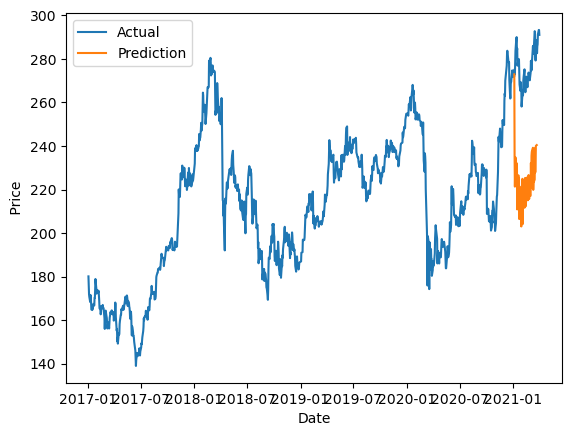

In [77]:
sns.lineplot(Original, x='Date', y=' Price ', label='Actual')
sns.lineplot(df_forecast, x='Date', y='Price', label='Prediction')
plt.legend()

In [69]:
actual_y= pd.DataFrame(test_Y, columns=["real_price"])
pred_y= pd.DataFrame(forecast, columns=["pred_price"])
real_pred = pd.concat([actual_y, pred_y], axis=1, join="inner")
real_pred

,real_price,pred_price
0,288.65,240.416458
1,285.47,240.047028
2,279.25,234.787155
3,283.35,227.890121
4,292.33,239.027222
5,292.74,224.579742
6,284.93,223.470261
7,286.00,224.834595
8,282.24,219.855453
9,285.79,239.183182
